# Optimal charging station location on a cycleway


Consider a long linear cycle path  as Vento (VENezia-TOrino), or the Danube cycle path. The cycle path usually runs along the banks of a river with scarse tourist interest. However, from the main course of the cycle path it is possible to reach places of tourist interest by making small detours.  

The rapid growth of e-bike ridership is proposing the problem of deploying a suitable charging infrastructure. The charging stations should be placed in strategic positions so as to guarantee a coverage of the whole cycle path. However, since the charging operations require a non negligible time, the charging station should be positioned in places where alternative activities could be carried out, as restaurants, museums, swimming pool, or other amenities. These places, called **Points of Interest (POI)**  are not on the main trajectory of the cyclepath, but the bikers must deviate to reach them.

We assume that the bikers enter the cyclepath where it begins and finish the trip ath the end of the cyclepath. When they enter the battery is fully charged. Moreover, the bikers will make all possible deviations in order to visit all the POIs.







## Formulation

To support the formulation we make use of a graph with $2n+2$ nodes.
Nodes $s$ and $t$ represent the extremes of the cyclepath.

Nodes

*   $L = \{1,\ldots,n\}$:  locations along the cyclepath from which bikers deviate


*   $H = \{1',\ldots, n'\}$:  POIs that may host a charging station.

*   $\{s,t\}$: extremes of the cyclepath.

Arcs

*  $\{(i,i+1), (i+1, i) 1,\ldots,n \}$: arcs of the cyclepath in the two directions

*  $\{(i,i'), (i',i), i\in L, i'\in H\}$: arcs representing the deviations from the cyclepath

### Example of the graph
![picture](https://drive.google.com/file/d/1A4dSP-4K1E3jwaab4A8JT21TKD7FINaK/view?usp=drive_link)

### Parameters

*   $d_{i,i+1}, d_{i+1,i}, i=1,\ldots,n-1$: energy consumption between consecutive nodes,
*   $d_{i,i'}, d_{i',i}, i \in L, i'\in H$: energy consumption for the deviations
*   $c_i'$: cost of installing a charging station in site $i' \in H$
*   $\Delta$: maximum energy consumption between consecutive charging stations

We assume that $d_{s,1} d_{1,s} = d_{n,t} = d_{t,n} = 0$.
Note that the energy consumption on each arc can be different in the two directions, depending on the orography.








## Problem 1

Consider a biker that traverses the cyclepath from $s$ to $t$, determine in which nodes of $H$ to install the charging stations so that the maximum energy consumption between two consecutive charging stations is no more than $\Delta$ and minimize the overall cost.



## Problem 2

Consider a biker that traverses the cyclepath from $t$ to $s$, determine in which nodes of $H$ to install the charging stations so that the maximum energy consumption between two consecutive charging stations is no more than $\Delta$ and minimize the overall cost.

### Comments
Do you obtain the same solution? Why?

### Recommendation
The problems can be solved by a simple formulation. The solution of complex problems as the TSP is not necessary.
Do not use external libraries apart from those presented in class.



## EMANUELE CARUSO, ANGELO PRETE
Risoluzione del progetto di Laboratorio

In [30]:
#import libraries

# !pip install mip
# !pip install --upgrade cffi==1.15.0
import importlib
import cffi
importlib.reload(cffi)
import numpy as np
import math
import networkx as nx

## Solution Problem 1

In [31]:
#data PROBLEM 1

n = 15  # number of nodes on the main course
n1 = 15 #number of touristic sites
delta = 50  # max distance before recharge
s = 0   # starting point
t = n+1  # destination
consumption = [20, 32, 11, 37, 7, 14, 22, 5, 35, 17, 23, 3, 26, 24] # consumption (in Wh) between two consecutive location along the main course
consumption_deviation = [1.1, 0.7, 0.4, 0.9, 2.1, 1.8, 0.5, 0.4, 1.6, 2.5, 1.4, 0.8, 2.0, 1.3, 0.1] # consumption (in Wh) of the deviation
inst_cost = [1492, 1789, 1914, 1861, 1348, 1769, 1123, 1432, 1564, 1818, 1901, 1265, 1642, 1712, 1756] #cost (in €) of installation of a charging point related to the node

### Modifica dei dati

Seguendo l'immagine lasciata in allegato alla traccia, abbiamo deciso per semplificare l'implementazione di considerare l'insieme dei nodi $N = \{s,1',\ldots,n',t\}$ e quindi l'uscita dal cycle path sarà nel nodo $t = n+1$ e non $t=n$.

Inoltre, per coerenza, abbiamo aggiunto agli array consumption e consumption_deviation i consumi fittizzi di $s$ e $t$ pari a $0$. Questo vale anche per i costi di installazione. Come vedremo, infatti, per considerare la bici carica all'inizio il costo di installazione in $s$ (e nel problema 2 in $t$) è $0$ e viene sempre scelta nella soluzione ottima (anche se lo tagliamo via dalla stampa finale del risultato).

### Grafo equivalente

Assumendo che la consumption della deviazione debba essere considerato sia verso il POI che al ritorno verso la tappa corrispondente al POI, abbiamo deciso di costruire il grafo nel seguente modo:

il grafo equivalente è $G = (N, A)$ con $N = \{s,1',...,n',t\}$ ovvero $s$,$t$ e i POI.

l'insieme degli archi è $A = {(i,j): i<j, b_{ij} < \Delta , \forall (i,j) \in A }$ quindi il grafo è aciclico

$b$ rappresenta il consumo totale tra due nodi pari alla somma delle consumption_new del grafo equivalente, pari invece a
$consumption\_new[i] =  consumption\_deviation[i] +  consumption[i] + consumption\_deviation[i+1]$

Ovvero il peso di ogni arco tra nodi successivi è pari al costo della deviazione del nodo di partenza, il costo del tragitto tra i due nodi e il costo della deviazione del nodo di arrivo (i nodi di arrivo sono quelli che nel problema originale erano $i'$)


In [32]:
#build the equivalent graph

# Il grafo equivalente è G = (N, A)
# N = {s,1',...,n',t} ovvero s,t e i POI
# A = {(i,j): i<j, b_ij < delta per ogni (i,j) in A } quindi il grafo è aciclico
# e dove b rappresenta il consumo tra due nodi, in particolare b_i,i+1 = (guarda foto telegram)

#define the set of nodes
V = [i for i in range(n+2)] # node 0 , node n+1 rappresentano rispettivamente s t

# Updatating consuption array to take account of new V representation
consumption.insert(0, 0)
consumption.append(0)

consumption_deviation.insert(0, 0)
consumption_deviation.append(0)

inst_cost.insert(0, 0)
inst_cost.append(0)

#come spiegato sopra, definiamo l'array consumption_new
consumption_new = [consumption[i] + consumption_deviation[i] + consumption_deviation[i+1] for i in range(n+1)]


#define the set of edges
#tutti gli archi validi hanno la somma dei consumi dal nodo di partenza al nodo di arrivo minore o uguale a DELTA
A = {(i,j): sum(consumption_new[i:j]) for i in range(n+1) for j in range(i+1, n+2) if sum(consumption_new[i:j])<=delta }
print(A)


{(0, 1): 1.1, (0, 2): 22.900000000000002, (1, 2): 21.8, (2, 3): 33.1, (2, 4): 45.400000000000006, (3, 4): 12.3, (4, 5): 40.0, (5, 6): 10.9, (5, 7): 27.200000000000003, (6, 7): 16.3, (6, 8): 39.2, (6, 9): 46.2, (7, 8): 22.9, (7, 9): 29.9, (8, 9): 7.0, (8, 10): 46.1, (9, 10): 39.1, (10, 11): 20.9, (10, 12): 46.099999999999994, (11, 12): 25.2, (11, 13): 31.0, (12, 13): 5.8, (12, 14): 35.1, (13, 14): 29.3, (14, 15): 25.400000000000002, (14, 16): 25.500000000000004, (15, 16): 0.1}


## MODELLO

Per modelizzare il problema, abbiamo dichiarato la variabile binaria $ y \in \{0,1\}$  che vale 1 se l'arco viene considerato o 0 altrimenti.
Il vettore dei termini noti b serve per esprimere il vincolo di passare per tutte le stazioni, ovvero: $\forall i \in V$ la somma degli archi entranti da un nodo meno la somma di quelli uscenti deve essere uguale a b[i].
La funzione obiettivo vuole minimizzare il costo di installazione delle stazioni nei POI.

In [33]:
import mip

# Create model
m = mip.Model()

# define the variable

# variabili archi
y = {i: m.add_var(var_type=mip.BINARY) for i in A }

#  define the contraints

# vincolo per indicare il passaggio per tutte le stazioni
b = {i: 0 for i in V}
b[s] = -1 # first node
b[t] = 1 # last node

for i in V:
    m.add_constr(mip.xsum(y[(j,i)] for j in V if (j,i) in A)-(mip.xsum(y[(i,j)] for j in V if (i,j) in A)) == b[i])

#Funzione Obiettivo
# minimize cost of installation
m.objective = mip.minimize(
    mip.xsum(inst_cost[i]*y[(i,j)] for (i,j) in A)
)

# in 0 viene messa di Deafult una stazione in quanto il costo di installazione è 0 per simulare l'autonomia di partenza = delta
#Per comodità di lettura, evitiamo di stamparla

m.optimize()

res = []
for (i,j) in A:
    if(y[(i,j)].x > 0.9 and y[(i,j)].x < 1.1):
        if(i>0):
            print(i)
            res.append(i)
print(res)

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 6 (-11) rows, 10 (-17) columns and 20 (-34) elements
Clp1000I sum of infeasibilities 0 - average 0, 10 fixed columns
Coin0506I Presolve 0 (-6) rows, 0 (-10) columns and 0 (-20) elements
Clp0000I Optimal - objective value 12348
Clp0000I Optimal - objective value 12348
Coin0511I After Postsolve, objective 12348, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 12348 Dual inf 3250 (2)
Clp0000I Optimal - objective value 12348
Clp0000I Optimal - objective value 12348
Clp0000I Optimal - objective value 12348
Coin0511I After Postsolve, objective 12348, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 12348 - 0 iterations time 0.002, Presolve 0.00, Idiot 0.00

Starting MIP optimization
Cgl0003I 0 fixed, 0 tightened bounds, 0 strengthened rows, 1 substitutions
Cgl0004I processed model has 2 rows, 3 columns (3 integer (3 of which binary)) and 6 elements
Coin3009W

In [34]:
print(m.objective_value)

12348.0


### Visualizzazione del percorso
Questa sezione è preposta alla visione dei POI in cui è necessario installare le stazioni.
Abbiamo disegnato la rappresentazione equivalente del percorso.

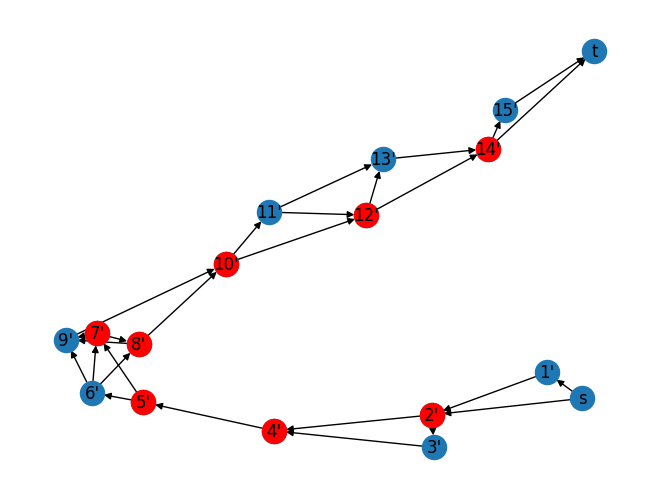

In [35]:
#DISEGNA GRAFO
G = nx.DiGraph()
G.add_nodes_from(V)
G.add_edges_from(A)
labels = {i: (str(i) + '\'') for i in V if i!=s and i!=t}
labels[s] = 's'
labels[t] = 't'
pos = nx.spring_layout(G)  # layout per la disposizione dei nodi
nx.draw(G, pos, with_labels=True, labels=labels)
nx.draw_networkx_nodes(G,pos,nodelist=res,node_color='r')


## Solution Problem 2

## Considerazioni del Problema 2
Per costruire il grafo equivalente valgono le stesse considerazioni scritte sopra del Problema 1.
La differenza è che il nodo t (nodo di arrivo Problema 1) diventa il nodo sorgente, mentre s (nodo sorgente Problema 1) diventa il nodo destinazione.


In [36]:
#data PROBLEM 2

n = 15  # number of nodes on the main course
n1 = 15 #number of touristic sites
delta = 50  # max distance before recharge
t = n+1   # starting point
s = 0  # destination
consumption = [12, 24, 7, 8, 35, 21, 19, 9, 31, 15, 21, 6, 23, 29] # consumption (in Wh) between two consecutive location along the main course
consumption_deviation = [1.7, 2.1, 1.1, 0.3, 0.4, 2.3, 0.2, 0.9, 2.1, 4.3, 5.2, 0.1, 2.8, 0.9, 0.1] # consumption (in Wh) of the deviation

#to compute the installation cost you have to bring the vector from the PROBLEM 1 and reverse it
inst_cost = inst_cost[::-1]


In [37]:
#build the equivalent graph

# Il grafo equivalente è G = (N, A)
# N = {t,1',...,n',s} ovvero t,s e i POI
# A = {(i,j): i>j, b_ij < delta per ogni (i,j) in A } quindi il grafo è aciclico come prima.
# dove la consumption_new rappresenta il consumo "equivalente" tra due nodi (come problema 1).

#define the set of nodes
V = [i for i in range(n+2)] # node 0 and node n+1 rappresentano risp. t e s

# Updatating consuption array to take account of new V representation
consumption.insert(0, 0)
consumption.append(0)

consumption_deviation.insert(0, 0)
consumption_deviation.append(0)

consumption_new = [consumption[i] + consumption_deviation[i] + consumption_deviation[i+1] for i in range(n+1)]

#define the set of edges
#Per indicizzare correttamente l'array consumption_new, essendo invariata la numerazione dei vertici, utilizziamo gli indici i,j per iterare l'array in reverse sottraendoli a t.
A = {(i,j): sum(consumption_new[(t-i):(t-j)]) for i in range(t,s,-1) for j in range(i-1, s-1, -1) if sum(consumption_new[(t-i):(t-j)])<=delta }

In [38]:
import mip

# Create model
m = mip.Model()

# define the variable

# variabili archi
y = {i: m.add_var(var_type=mip.BINARY) for i in A }

#  define the contraints

# vincolo passo per tutte le stazioni
# rispetto al problema 1 invertiamo i valori di b[s] e b[t] in quanto s è diventato il nuovo punto di arrivo
b = {i: 0 for i in V}
b[s] = 1
b[t] = -1

for i in V:
    m.add_constr(mip.xsum(y[(j,i)] for j in V if (j,i) in A)-(mip.xsum(y[(i,j)] for j in V if (i,j) in A)) == b[i])

# minimize cost of installation
m.objective = mip.minimize(
    mip.xsum(inst_cost[i]*y[(i,j)] for (i,j) in A)
)
#Anche in questo caso per simulare la partenza da t con autonomia = delta la stazione 16 (t) viene scelta sempre avendo costo 0.
#Per comodità di lettura, evitiamo di stamparla
m.optimize()
res2 = []
for (i,j) in A:
    if(y[(i,j)].x > 0.9 and y[(i,j)].x < 1.1):
      if(i<16):
        print(i)
        res2.append(i)

print(res2)


Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 7 (-10) rows, 13 (-16) columns and 26 (-32) elements
Clp1000I sum of infeasibilities 0 - average 0, 13 fixed columns
Coin0506I Presolve 0 (-7) rows, 0 (-13) columns and 0 (-26) elements
Clp0000I Optimal - objective value 13034
Clp0000I Optimal - objective value 13034
Coin0511I After Postsolve, objective 13034, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 13034 Dual inf 4906 (3)
Clp0000I Optimal - objective value 13034
Clp0000I Optimal - objective value 13034
Clp0000I Optimal - objective value 13034
Coin0511I After Postsolve, objective 13034, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 13034 - 0 iterations time 0.002, Presolve 0.00, Idiot 0.00

Starting MIP optimization
Cgl0003I 0 fixed, 0 tightened bounds, 0 strengthened rows, 1 substitutions
Cgl0004I processed model has 5 rows, 10 columns (10 integer (10 of which binary)) and 18 elements
Coin3

In [39]:
print(m.objective_value)

13034.0


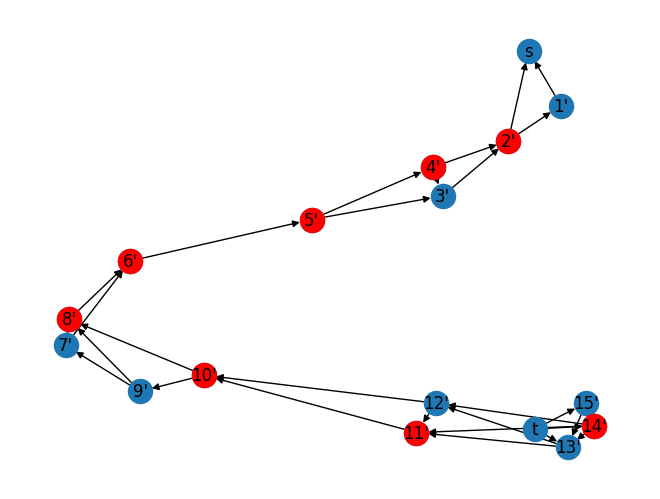

In [40]:
#DISEGNA GRAFO
G = nx.DiGraph()
G.add_nodes_from(V)
G.add_edges_from(A)
labels = {i: (str(i) + '\'') for i in V if i!=s and i!=t}
labels[s] = 's'
labels[t] = 't'
pos = nx.spring_layout(G)  # layout per la disposizione dei nodi
nx.draw(G, pos, with_labels=True, labels=labels)
nx.draw_networkx_nodes(G,pos,nodelist=res2,node_color='r')


## Comment

Do you obtain the same solution? Why?

Non otteniamo la stessa soluzione perché i percorsi non hanno consumi simmetrici. 
Questo è giustificabile fisicamente, ad esempio, perché una stessa strada se è in pendenza può avere un consumo energetico diverso in base al verso di percorrenza.
Inoltre, un altro effetto del cambio di verso di percorrenza è che, sempre a causa dei consumi diversi, con la stessa ricarica posso percorrere un tragitto diverso.